In [1]:
# mount GDrive
from google.colab import drive
#drive.mount('/content/drive')
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/" .


In [3]:
%pylab inline
import pandas as pd
import glob

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load duplicated lyrics
duplicated_songs = pd.read_json("dataset_10/final_duplicates_and_covers.json")
duplicated_songs.head()

,song_id,duplicated_of,cover_of,is_duplicated,is_cover
0,5714deec25ac0d8aee5735f8,5714deec25ac0d8aee573522,None,True,False
1,5714dec625ac0d8aee3a5ee7,5714dec625ac0d8aee3a5d8d,None,True,False
2,5714ded925ac0d8aee493bfd,5714ded925ac0d8aee493af6,None,True,False
3,5714ded925ac0d8aee493c75,5714ded925ac0d8aee493af6,None,True,False
4,5714ded925ac0d8aee493ca1,5714ded925ac0d8aee493af6,None,True,False


In [5]:
# get song dataset

data_folders = ['dataset_10/data_lyrics_person_decades/', 'dataset_10/data_lyrics_group_decades/']

song_lyrics = []

for data_folder in data_folders:
    type_ = data_folder.split('_')[-2]
    for file in glob.glob(data_folder+'*_[!.]*.json.gz'): # skip songs with no dates

        data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
        for chunk in data_chunk:        

            chunk = chunk[['song_id', 'song_title', 'language_detect', 'lyrics', 'n_words', 'n_lines', 'artist_id', 'artist_name',
                            'song_pubdate_combined', 'song_year_combined', 'song_decade_combined', 'other_artist_info',
                           'urlSpotify']]
            song_lyrics.append(chunk)

song_lyrics = pd.concat(song_lyrics)
print('Total number of song lyrics: ', song_lyrics.shape[0])
song_lyrics.head()

Total number of song lyrics:  460339


,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,urlSpotify
0,5714dec325ac0d8aee380b13,Tears All Over Town,english,Ride the subway home\nPretend that you're not ...,192,33,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'...",https://play.spotify.com/track/4qFoqfiUAeQtVCD...
1,5714dec325ac0d8aee380b14,Kathleen,english,If I don't laugh i'll cry\nAt all the years go...,201,39,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'...",https://play.spotify.com/track/2onTBjCi7in4Csr...
2,5714dec325ac0d8aee380b15,Girls Can Really Tear You Up Inside,english,There's a girl whose stuck inside a picture fr...,233,38,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'...",https://play.spotify.com/track/1MgVqQRA1FFJhci...
3,5714dec325ac0d8aee380b16,The Long Goodbye,english,You stormed my winter palace\nYou rid my heart...,202,36,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'...",https://play.spotify.com/track/0JJbwZAwLxIsvzM...
4,5714dec325ac0d8aee380b17,Somebody Hurt You,english,Boy\nSomebody hurt you\nBoy\nI wish I knew who...,210,42,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'...",https://play.spotify.com/track/56sirv4qFk7Pa9O...


In [6]:
# add the columns corresponding to cover and duplicates
song_lyrics = song_lyrics.merge(duplicated_songs, on='song_id', how='left')
song_lyrics.loc[:, 'is_duplicated'] = song_lyrics.is_duplicated.fillna(False)
song_lyrics.loc[:, 'is_cover'] = song_lyrics.is_cover.fillna(False)

In [11]:
# extract artist type
song_lyrics.loc[:, 'artist_type'] = song_lyrics.other_artist_info.apply(lambda art_info: art_info['type'])

### Raw numbers

In [65]:
idxs_duplicated_covers = (song_lyrics.is_cover)|(song_lyrics.is_duplicated)
idxs_person = song_lyrics.artist_type=='Person'
idxs_group = song_lyrics.artist_type=='Group'

print("Number of song lyrics in the dataset: ", song_lyrics.shape[0])
print("Number of song lyrics in the dataset (no cover/duplicates): ", song_lyrics[~idxs_duplicated_covers].shape[0])
print()
print("Number of songs by Person artist: ", song_lyrics[idxs_person].shape[0])
print("Number of songs by Group artist: ", song_lyrics[idxs_group].shape[0])
print("Number of songs by Person artist (no cover/duplicates): ", song_lyrics[(~idxs_duplicated_covers)&(idxs_person)].shape[0])
print("Number of songs by Group artist (no cover/duplicates): ", song_lyrics[(~idxs_duplicated_covers)&(idxs_group)].shape[0])
print()
print("Single person artists")
print("Number of song lyrics by male artists: ", song_lyrics[idxs_person].other_artist_info.apply(lambda a_info: a_info['gender']=='Male').sum())
print("Number of song lyrics by female artists: ", song_lyrics[idxs_person].other_artist_info.apply(lambda a_info: a_info['gender']=='Female').sum())
print("Number of song lyrics by male artists (no cover/duplicates): ", 
      song_lyrics[(idxs_person)&(~idxs_duplicated_covers)].other_artist_info.apply(lambda a_info: a_info['gender']=='Male').sum())
print("Number of song lyrics by female artists (no cover/duplicates): ", 
      song_lyrics[(idxs_person)&(~idxs_duplicated_covers)].other_artist_info.apply(lambda a_info: a_info['gender']=='Female').sum())
print()
print('Group artists')
# group artists with all male or all females
n_songs_group = song_lyrics[idxs_group].shape[0]
n_groups_all_male = song_lyrics[idxs_group].other_artist_info.apply(lambda a_info: a_info['n_male']==a_info['n_members']).sum()
n_groups_all_female = song_lyrics[idxs_group].other_artist_info.apply(lambda a_info: a_info['n_female']==a_info['n_members']).sum()
n_groups_mix = song_lyrics[idxs_group].other_artist_info.apply(lambda a_info: a_info['n_female']!=0 and a_info['n_male']!=0 and a_info['n_unknown']==0).sum()
n_groups_unknown_members = song_lyrics[idxs_group].other_artist_info.apply(lambda a_info: a_info['n_unknown']>0).sum()

print("Total number of songs of Group artists: ", song_lyrics[idxs_group].shape[0])
print("Fraction of songs from all male Group artists (%): ", round(n_groups_all_male/n_songs_group * 100, 2))
print("Fraction of songs from all female Group artists (%): ", round(n_groups_all_female/n_songs_group * 100, 2))
print("Fraction of songs from mixed gender Group artists (%): ", round(n_groups_mix/n_songs_group * 100, 2))
print("Fraction of songs Group artists with unknown gender of at least one member (%): ", round(n_groups_unknown_members/n_songs_group * 100, 2))

Number of song lyrics in the dataset:  460339
Number of song lyrics in the dataset (no cover/duplicates):  370284

Number of songs by Person artist:  297402
Number of songs by Group artist:  162937
Number of songs by Person artist (no cover/duplicates):  237846
Number of songs by Group artist (no cover/duplicates):  132438

Single person artists
Number of song lyrics by male artists:  209239
Number of song lyrics by female artists:  88163
Number of song lyrics by male artists (no cover/duplicates):  166966
Number of song lyrics by female artists (no cover/duplicates):  70880

Group artists
Total number of songs of Group artists:  162937
Fraction of songs from all male Group artists (%):  77.23
Fraction of songs from all female Group artists (%):  4.6
Fraction of songs from mixed gender Group artists (%):  18.17
Fraction of songs Group artists with unknown gender of at least one member (%):  0.0


### Plot number of songs across year

Total number of songs :  460339
Total number of song lyrics by Persons:  297402
Total number of song lyrics by Groups:  162937


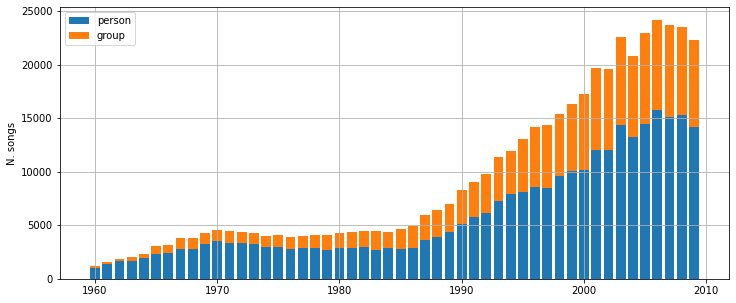

In [53]:
# get number of song lyrics per year and per type of artist
n_songs_year = song_lyrics.groupby('song_year_combined').apply(lambda rows: 
                                                                   rows.artist_type.value_counts().reindex(['Person', 'Group'], fill_value=0))


print("Total number of songs : ", song_lyrics.shape[0])
print("Total number of song lyrics by Persons: ", n_songs_year.Person.sum())
print("Total number of song lyrics by Groups: ", n_songs_year.Group.sum())

# number of songs across time
plt.figure(figsize=(12,5))

plt.bar(n_songs_year.index, n_songs_year.Person, label='person')
plt.bar(n_songs_year.index, n_songs_year.Group, label='group', bottom=n_songs_year.Person)

plt.ylabel("N. songs")
plt.legend()
plt.grid()

Total number of songs from Person artists :  297402
Total number of song lyrics by Male Person artists:  209239
Total number of song lyrics by Female Person artists:  88163


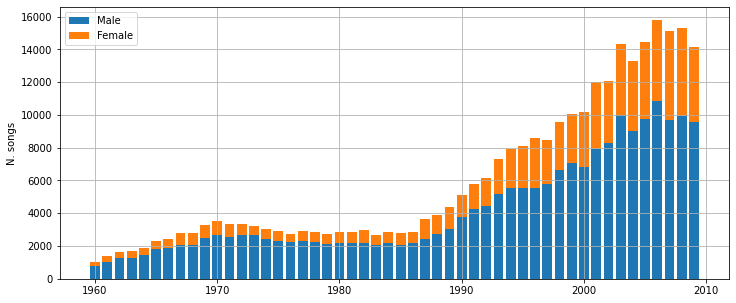

In [55]:
# Person artist gender
n_songs_person_gender = song_lyrics[song_lyrics.artist_type=='Person'].groupby('song_year_combined').apply(lambda rows: 
                            rows.other_artist_info.apply(lambda a_info: a_info['gender']).value_counts().reindex(['Male', 'Female'], fill_value=0))

print("Total number of songs from Person artists : ", song_lyrics.artist_type.value_counts()['Person'])
print("Total number of song lyrics by Male Person artists: ", n_songs_person_gender.Male.sum())
print("Total number of song lyrics by Female Person artists: ", n_songs_person_gender.Female.sum())

plt.figure(figsize=(12,5))

plt.bar(n_songs_person_gender.index, n_songs_person_gender.Male, label='Male')
plt.bar(n_songs_person_gender.index, n_songs_person_gender.Female, label='Female', bottom=n_songs_person_gender.Male)

plt.ylabel("N. songs")
plt.legend()
plt.grid()

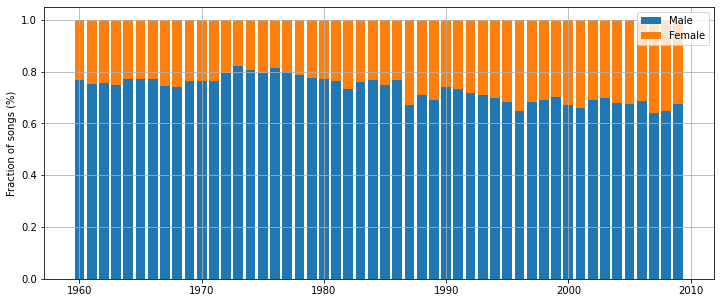

In [23]:
# fractions
n_songs_person_gender.loc[:, 'Total'] = n_songs_person_gender.Male + n_songs_person_gender.Female

plt.figure(figsize=(12,5))

plt.bar(n_songs_person_gender.index, n_songs_person_gender.Male/n_songs_person_gender.Total, label='Male')
plt.bar(n_songs_person_gender.index, n_songs_person_gender.Female/n_songs_person_gender.Total, label='Female', 
        bottom=n_songs_person_gender.Male/n_songs_person_gender.Total)

plt.ylabel("Fraction of songs (%)")
plt.legend()
plt.grid()

### Group artists

In [52]:
# group artists with all male or all females
n_songs_group = song_lyrics[song_lyrics.artist_type=='Group'].shape[0]
n_groups_all_male = song_lyrics[song_lyrics.artist_type=='Group'].other_artist_info.apply(lambda a_info: a_info['n_male']==a_info['n_members']).sum()
n_groups_all_female = song_lyrics[song_lyrics.artist_type=='Group'].other_artist_info.apply(lambda a_info: a_info['n_female']==a_info['n_members']).sum()

n_groups_mix = song_lyrics[song_lyrics.artist_type=='Group'].other_artist_info.apply(lambda a_info: 
                                                                                     a_info['n_female']!=0 and a_info['n_male']!=0 and a_info['n_unknown']==0).sum()

n_groups_unknown_members = song_lyrics[song_lyrics.artist_type=='Group'].other_artist_info.apply(lambda a_info: 
                                                                                     a_info['n_unknown']>0).sum()

print("Total number of songs of Group artists: ", song_lyrics[song_lyrics.artist_type=='Group'].shape[0])
print("Fraction of songs from all male Group artists (%): ", round(n_groups_all_male/n_songs_group * 100, 2))
print("Fraction of songs from all female Group artists (%): ", round(n_groups_all_female/n_songs_group * 100, 2))
print("Fraction of songs from mixed gender Group artists (%): ", round(n_groups_mix/n_songs_group * 100, 2))
print("Fraction of songs Group artists with unknown gender of at least one member (%): ", round(n_groups_unknown_members/n_songs_group * 100, 2))

Total number of songs of Group artists:  162937
Fraction of songs from all male Group artists (%):  77.23
Fraction of songs from all female Group artists (%):  4.6
Fraction of songs from mixed gender Group artists (%):  18.17
Fraction of songs Group artists with unknown gender of at least one member (%):  0.0
